In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Cell 1 — Setup: paths, imports, knobs
import os, json, math, time, gc
from typing import List, Optional

import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm

import torch

PROJ      = "/content/drive/MyDrive/VQAScore_Project"
DATA_CSV  = f"{PROJ}/data/genai_bench_subset.csv"
TEMPLATES = f"{PROJ}/data/templates.json"      # created in Phase 1
OUT_CSV   = f"{PROJ}/results/raw_scores.csv"   # baseline (single template)
BATCH_CLIP = 16                                # CLIPScore batch size

device = "cuda" if torch.cuda.is_available() else "cpu"

print("Project:", PROJ)
print("Device:", device)
print("Input CSV:", DATA_CSV)
print("Output CSV:", OUT_CSV)

Project: /content/drive/MyDrive/VQAScore_Project
Device: cuda
Input CSV: /content/drive/MyDrive/VQAScore_Project/data/genai_bench_subset.csv
Output CSV: /content/drive/MyDrive/VQAScore_Project/results/raw_scores.csv


In [ ]:
# Cell 2 — Load dataset and pick a single baseline question template
df = pd.read_csv(DATA_CSV)

# Sanity checks
assert {"id","prompt","image_path"}.issubset(df.columns), \
    "CSV must contain id, prompt, image_path columns."

templates = json.load(open(TEMPLATES))["templates"] if os.path.exists(TEMPLATES) else [
    'Does this figure show "{}"? Please answer yes or no.'
]
BASE_TEMPLATE = templates[0]  # baseline, you'll vary in Phase 4
print("Using baseline template:", BASE_TEMPLATE)

# Keep only rows with existing images
df = df[df["image_path"].map(lambda p: isinstance(p,str) and os.path.exists(p))].reset_index(drop=True)
print("Rows with images:", len(df))
df.head(3)


Using baseline template: Does this figure show "{}"? Please answer yes or no.
Rows with images: 1341


,id,prompt,category,image_path
0,604,"The moon casts a soft glow on the garden, a ra...",compositional,/content/drive/MyDrive/VQAScore_Project/data/g...
1,147,One content rabbit and six tired turtles.,compositional,/content/drive/MyDrive/VQAScore_Project/data/g...
2,824,Two computers equipped with unique circular di...,compositional,/content/drive/MyDrive/VQAScore_Project/data/g...


In [ ]:
# Cell 0 — Make Drive-installed t2v_metrics importable in THIS runtime
import os, sys

# 2) Path to your Drive install (adjust if you put it elsewhere)
T2V_PATH = "/content/drive/MyDrive/VQAScore_Project/t2v_metrics"

# 3) EITHER: add the repo source to sys.path (fast, no reinstall needed)
if T2V_PATH not in sys.path:
    sys.path.append(T2V_PATH)

# 4) Try import; if it still fails, do a lightweight editable install from Drive
try:
    import t2v_metrics
except Exception as e:
    print("Direct import failed, doing editable install from Drive…", e)
    # This only writes an egg-link into the *current* session's site-packages (fast)
    # 2) Install minimal dependencies manually (skip heavy extras like flash-attn)
    %pip install --quiet --upgrade pip
    %pip install --quiet einops pandas numpy scipy tqdm pillow
    %pip install --quiet transformers accelerate datasets
    %pip install --quiet open_clip_torch
    %pip install --quiet diffusers==0.30.0

    # 3) Make sure flash-attn is removed (not needed here)
    !pip uninstall -y flash-attn || true
    !pip install -e "$T2V_PATH"
    import t2v_metrics

from t2v_metrics import metrics
print("t2v_metrics ready ✔")
import importlib, inspect
print("Loaded from:", os.path.dirname(inspect.getfile(t2v_metrics)))

In [ ]:
# Cell 3 — Try t2v_metrics first; if unavailable, we'll use a robust fallback
USE_T2V = False
try:
    import t2v_metrics
    from t2v_metrics import metrics
    USE_T2V = True
    print("t2v_metrics found ✔")
except Exception as e:
    print("t2v_metrics not available or import failed, using fallback:", e)

t2v_metrics not available or import failed, using fallback: No module named 'iopath'


In [ ]:
# Cell 4 — Build CLIPScore (either via t2v_metrics or fallback with open_clip)
if USE_T2V:
    clip_metric = metrics.build_metric("clipscore", model_name="ViT-B-32")  # adjust if you prefer ViT-L
    print("CLIPScore via t2v_metrics ready.")
else:
    import open_clip
    clip_model, _, clip_preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai')
    clip_tokenizer = open_clip.get_tokenizer('ViT-B-32')
    clip_model = clip_model.to(device).eval()
    print("CLIPScore fallback (open_clip) ready.")

def compute_clip_scores_batch(img_paths: List[str], texts: List[str]) -> List[float]:
    """Returns cosine similarity per (image, text)."""
    if USE_T2V:
        # t2v_metrics unified interface (typically single pair, but supports batch in some versions).
        # We'll do a simple loop for clarity & compatibility.
        out = []
        for p, t in zip(img_paths, texts):
            img = Image.open(p).convert("RGB")
            out.append( clip_metric.score_image_text(img, t) )
        return out
    else:
        with torch.no_grad():
            images = torch.stack([clip_preprocess(Image.open(p).convert("RGB")) for p in img_paths]).to(device)
            tokens = clip_tokenizer(texts)
            image_features = clip_model.encode_image(images)
            text_features  = clip_model.encode_text(tokens.to(device))
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features  /= text_features.norm(dim=-1, keepdim=True)
            sims = (image_features @ text_features.T).diag().detach().float().cpu().tolist()
        torch.cuda.empty_cache()
        return sims

In [ ]:
# Cell 5 — Build VQAScore (either via t2v_metrics or fallback with InstructBLIP)
VQA_BACKBONE = "llava"   # or "llava" if your env supports it well

if USE_T2V:
    vqa_metric = metrics.build_metric("vqascore", vqa_backbone=VQA_BACKBONE)
    print(f"VQAScore via t2v_metrics ({VQA_BACKBONE}) ready.")
else:
    from transformers import AutoProcessor, AutoModelForVision2Seq
    # Choose a lighter VQA model to fit comfortably on A100; adjust if you like
    # VQA_MODEL_ID = "Salesforce/instructblip-vicuna-7b"
    VQA_MODEL_ID = "Salesforce/instructblip-flan-t5-xl"
    vqa_processor = AutoProcessor.from_pretrained(VQA_MODEL_ID)
    vqa_model = AutoModelForVision2Seq.from_pretrained(
        VQA_MODEL_ID, torch_dtype=torch.float16 if device=="cuda" else torch.float32
    ).to(device).eval()
    print("VQAScore fallback (InstructBLIP) ready.")

@torch.inference_mode()
def vqa_yes_probability(image: Image.Image, prompt: str, template: str) -> float:
    """
    Approximate P(Yes | image, question) by comparing NLL of 'Yes' and 'No'
    answers and normalizing:
        p_yes = exp(-L_yes) / (exp(-L_yes) + exp(-L_no))
    This keeps scores in [0, 1] and makes them easier to interpret/compare.
    """
    question = template.format(prompt)

    # Encode the (image, question) once
    inputs = vqa_processor(images=image, text=question, return_tensors="pt").to(device)

    # Prepare target token ids for "Yes" and "No"
    yes_ids = vqa_processor.tokenizer("Yes", return_tensors="pt").input_ids.to(device)
    no_ids  = vqa_processor.tokenizer("No",  return_tensors="pt").input_ids.to(device)

    # Compute loss for each possible answer
    out_yes = vqa_model(**inputs, labels=yes_ids)
    out_no  = vqa_model(**inputs, labels=no_ids)

    nll_yes = float(out_yes.loss.item())
    nll_no  = float(out_no.loss.item())

    # Convert negative NLLs into normalized probabilities
    p_yes = math.exp(-nll_yes)
    p_no  = math.exp(-nll_no)
    denom = p_yes + p_no if (p_yes + p_no) > 0 else 1e-8

    return p_yes / denom

In [ ]:
def load_rgb_image(path: str) -> Image.Image:
    # Avoid animated frames or alpha; always return a single RGB frame
    im = Image.open(path)
    try:
        im.seek(0)  # if animated, take the first frame
    except Exception:
        pass
    return im.convert("RGB")

def normalize_vqa_inputs(inputs: dict, device: str) -> dict:
    """
    - Squeeze pixel_values from (B, 1, C, H, W) -> (B, C, H, W)
    - Move everything to device, but only cast pixel_values to fp16 on CUDA
    - Keep token tensors as Long/Int
    """
    out = {}

    # 1) Fix pixel_values shape
    if "pixel_values" in inputs:
        pv = inputs["pixel_values"]
        if pv.ndim == 5 and pv.shape[1] == 1:        # (B,1,C,H,W) -> (B,C,H,W)
            pv = pv.squeeze(1)
        elif pv.ndim != 4:
            # last-resort: keep the last 3 dims as (C,H,W)
            pv = pv.view(pv.shape[0], pv.shape[-3], pv.shape[-2], pv.shape[-1])

        # move & dtype only for pixel_values
        pv = pv.to(device)
        if device == "cuda":
            pv = pv.to(dtype=torch.float16)
        out["pixel_values"] = pv

    # 2) Copy the rest, move to device, but preserve dtype
    for k, v in inputs.items():
        if k == "pixel_values":
            continue
        if isinstance(v, torch.Tensor):
            out[k] = v.to(device)   # keep int64 for ids/masks, float32 where appropriate
        else:
            out[k] = v

    return out

In [ ]:
records = []
start_time = time.time()
# OUT_CSV   = f"{PROJ}/results/raw_scores_{start_time}.csv"

# NOTE: this only does the first batch for smoke testing, as in your snippet.
# For full run, use: range(0, len(df), BATCH_CLIP)
for i in tqdm(range(0, len(df), BATCH_CLIP), desc="Baseline scoring"):
    batch = df.iloc[i:i+BATCH_CLIP].copy()

    # 1) CLIPScore in batch (unchanged)
    clip_scores = compute_clip_scores_batch(
        img_paths=batch["image_path"].tolist(),
        texts=batch["prompt"].tolist()
    )

    # 2) VQAScore (PASS THE UNFORMATTED TEMPLATE HERE)
    vqa_scores = []
    for pth, text in zip(batch["image_path"].tolist(), batch["prompt"].tolist()):
        try:
            img = load_rgb_image(pth)
            s = vqa_yes_probability(img, text, BASE_TEMPLATE)
        except Exception as e:
            print(f"[warn] VQA fail on {pth}: {e}")
            s = float("nan")
        vqa_scores.append(s)

    # 3) Attach results + the human-readable, formatted question per row
    batch["CLIPScore"]   = clip_scores
    batch["VQAScore"]    = vqa_scores
    batch["model_clip"]  = "ViT-B-32"
    batch["model_vqa"]   = VQA_BACKBONE if USE_T2V else "instructblip-flan-t5-xl"
    batch["template"]    = [BASE_TEMPLATE.format(t) for t in batch["prompt"].tolist()]

    records.append(
        batch[["id","prompt","category","image_path","VQAScore","CLIPScore","model_vqa","model_clip","template"]]
    )

    # 4) Incremental save (survive Colab resets)
    if (i // BATCH_CLIP) % 5 == 0:
        pd.concat(records, ignore_index=True).to_csv(OUT_CSV, index=False)

# Final save
out_df = pd.concat(records, ignore_index=True)
out_df.to_csv(OUT_CSV, index=False)

elapsed = time.time() - start_time
print(f"Saved baseline scores to: {OUT_CSV} (elapsed: {elapsed/60:.1f} min)")
out_df.head(5)

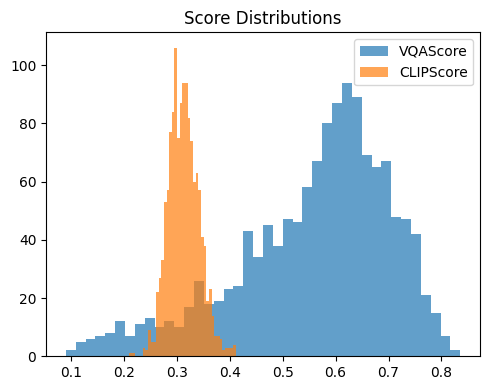

Spearman: 0.332 | Pearson: 0.300


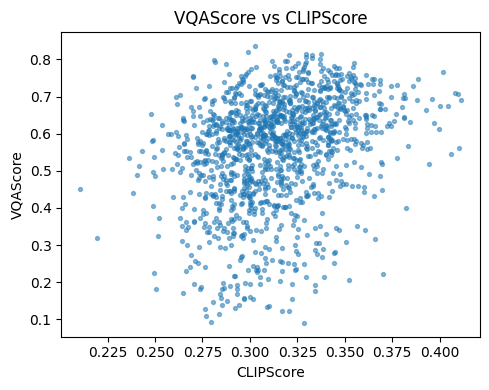

In [5]:
# Cell 7 — Quick sanity plots (optional but recommended)
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

df_scores = pd.read_csv(OUT_CSV)

fig, ax = plt.subplots(figsize=(5,4))
ax.hist(df_scores["VQAScore"], bins=40, alpha=0.7, label="VQAScore")
ax.hist(df_scores["CLIPScore"], bins=40, alpha=0.7, label="CLIPScore")
ax.set_title("Score Distributions")
ax.legend()
plt.tight_layout()
plt.savefig(f"{PROJ}/results/plots/score_distribution.png", dpi=140)
plt.show()

rho, _ = spearmanr(df_scores["VQAScore"], df_scores["CLIPScore"])
r, _   = pearsonr(df_scores["VQAScore"], df_scores["CLIPScore"])
print(f"Spearman: {rho:.3f} | Pearson: {r:.3f}")

plt.figure(figsize=(5,4))
plt.scatter(df_scores["CLIPScore"], df_scores["VQAScore"], s=8, alpha=0.5)
plt.xlabel("CLIPScore")
plt.ylabel("VQAScore")
plt.title("VQAScore vs CLIPScore")
plt.tight_layout()
plt.savefig(f"{PROJ}/results/plots/scatter_vqa_clip.png", dpi=140)
plt.show()

In [ ]:
# Cell 8 — Phase 3 summary
summary = {
    "rows_scored": int(len(df)),
    "out_csv": OUT_CSV,
    "clip_model": "ViT-B-32",
    "vqa_model": VQA_BACKBONE if USE_T2V else "instructblip-flan-t5-xl",
    "template_used": BASE_TEMPLATE
}
import pprint; pprint.pprint(summary)